# Check if discretizing the MD-Trajectory works

In [28]:
from MDAnalysis.lib.formats.libdcd import DCDFile
import numpy as np

traj = []
with DCDFile("../tests/Trajectories/ZIKV/trajectory.dcd") as f:
    for frame in f:
        traj.append(frame.xyz)
print(len(traj))

5001


In [29]:
np.array(traj).shape

(5001, 2977, 3)

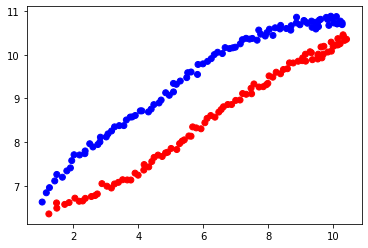

In [11]:
from MDAnalysis import Universe
import MDAnalysis.analysis.encore as encore
from MDAnalysis.tests.datafiles import PSF, DCD, DCD2
import matplotlib.pyplot as plt

ens1 = Universe(PSF, DCD)
ens2 = Universe(PSF, DCD2)
coordinates, details = encore.reduce_dimensionality([ens1, ens2])
plt.scatter(
    coordinates[0],
    coordinates[1],
    color=[["red", "blue"][m - 1] for m in details["ensemble_membership"]],
)

In [15]:
ens1 = Universe("../tests/Trajectories/ZIKV/trajectory.dcd")
coordinates, details = encore.reduce_dimensionality(ens1)

AttributeError: 'Topology' object has no attribute 'names'

In [5]:
from deeptime.data import sqrt_model

dtraj, traj = sqrt_model(n_samples=10000)

In [17]:
traj

array([[-5.18573987,  1.22733244],
       [-6.71045356,  1.5903144 ],
       [-3.28127219,  0.73881306],
       ...,
       [ 9.71996704,  4.20038916],
       [-5.71092724,  3.34319787],
       [ 6.03155811,  3.48683388]])

In [4]:
from torch.utils.data import DataLoader
from deeptime.util.data import TrajectoryDataset

dataset = TrajectoryDataset(1, traj.astype(np.float32))

n_val = int(len(dataset) * 0.5)
train_data, val_data = torch.utils.data.random_split(
    dataset, [len(dataset) - n_val, n_val]
)

loader_train = DataLoader(train_data, batch_size=64, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

NameError: name 'traj' is not defined